In [1]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import ensemble
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, precision_score
from transformers import BertTokenizer, BertModel
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

c:\Users\andsto\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Check if CUDA is available and set device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertModel.from_pretrained('bert-base-multilingual-cased').to(device)

Using device: cuda


In [3]:
class BERTVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, model, tokenizer, max_length=512):
        self.model = model
        self.tokenizer = tokenizer
        self.max_length = max_length

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        embeddings = []
        for sentence in X:
            inputs = self.tokenizer(sentence, return_tensors='pt', max_length=self.max_length, truncation=True, padding='max_length').to(device)
            with torch.no_grad():
                outputs = self.model(**inputs)
            cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()
            embeddings.append(cls_embedding)
        return embeddings

In [4]:
file_path = 'TRAINING_DATA.txt'
data = pd.read_csv(file_path, sep='\t', header=None, names=['label', 'sentence'])
data['label'] = data['label'].astype(int)

In [5]:
seed = 47
X_train, X_test, y_train, y_test = train_test_split(data['sentence'], data['label'], test_size=0.2, random_state=seed)

In [6]:
pipeline = Pipeline([
    ('bert', BERTVectorizer(model=model, tokenizer=tokenizer)),
    ('classifier', LogisticRegression(max_iter=1000, solver='lbfgs', class_weight='balanced', n_jobs=-1))
    # ('classifier', ensemble.RandomForestClassifier(n_estimators=51))
    # ('classifier', ensemble.RandomForestRegressor(n_jobs=-1))
])

In [7]:
# Train the model
model = pipeline.fit(X_train, y_train)

c:\Users\andsto\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\models\bert\modeling_bert.py:435: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


In [8]:
y_proba = pipeline.predict_proba(X_test)[:, 1]

In [9]:
threshold = 0.75  # Increase the threshold to reduce false positives
y_pred = (y_proba >= threshold).astype(int)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print('Classification Report:')
print(report)

Accuracy: 0.5319932998324958
Recall: 0.09802586793737236
Precision: 0.6666666666666666
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.95      0.67      1516
           1       0.67      0.10      0.17      1469

    accuracy                           0.53      2985
   macro avg       0.59      0.53      0.42      2985
weighted avg       0.59      0.53      0.43      2985



In [10]:
y_proba

array([0.74546058, 0.59892355, 0.68587721, ..., 0.41391352, 0.58800111,
       0.40055076])

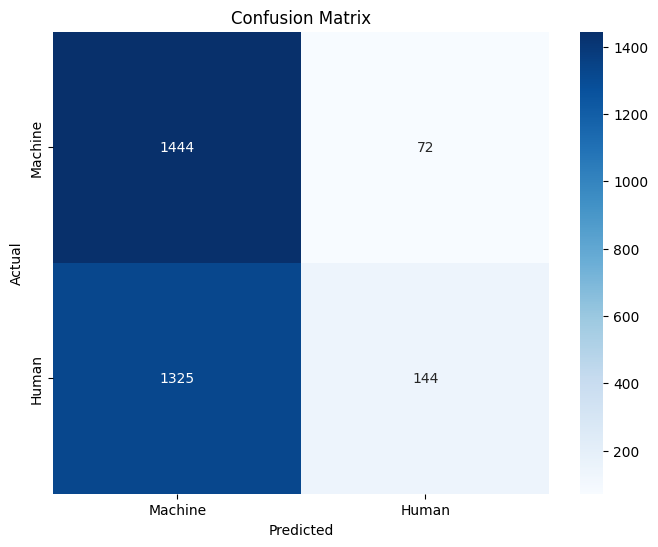

In [11]:
# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Machine', 'Human'], yticklabels=['Machine', 'Human'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [12]:
# import pickle

In [13]:
# with open(('sol6_model.pkl'), 'wb') as f:
#     pickle.dump(model, f)

In [12]:
# Load the new dataset
new_data = pd.read_csv('REAL_DATA.txt', delimiter='/t/t', header=None, names=['text'], engine='python')

# Preprocess the new data
# new_data['processed_text'] = new_data['text'].apply(preprocess_text)

X_new = new_data['text']

# Make predictions
new_data['predictions'] = model.predict(X_new)

threshold = 0.7  # Increase the threshold to reduce false positives
# y_pred = (y_proba >= threshold).astype(int)

def elevThreshold(val):
    return (val >= threshold).astype(int)

# Display the results
print(new_data.head())


                                                text  predictions
0  2\tYo no creo que a nadie le haya encantado un...            0
1  2\tNo va a resolver sus problemas de crédito o...            1
2                             2\tTe encantará este !            0
3  2\tYo estaba a volar a un aeropuerto varias ho...            0
4  2\t( Maid En Manhattan , The Wedding Planner ,...            0


In [13]:
def remove2tab(text : str):
    text = text.replace('2\t','')
    return text

new_data['text'] = new_data['text'].apply(remove2tab)

# new_data.drop(columns='processed_text', inplace=True)

In [14]:
pd.DataFrame.to_csv(new_data, 'Predictions_sol6.txt', index=False, sep='\t', columns=['predictions', 'text'])